In [19]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [17]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)    
    text = text.lower()
    
    words = word_tokenize(text)    
   
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def load_imdb_data():
    from keras.datasets import imdb
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data()

    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    train_reviews = [' '.join([reverse_word_index.get(i - 3, '?') for i in review]) for review in train_data]
    test_reviews = [' '.join([reverse_word_index.get(i - 3, '?') for i in review]) for review in test_data]

    train_df = pd.DataFrame({"review": train_reviews, "label": train_labels})
    test_df = pd.DataFrame({"review": test_reviews, "label": test_labels})

    return pd.concat([train_df, test_df]).reset_index(drop=True)

In [7]:
imdb_data = load_imdb_data()
imdb_data['review'] = imdb_data['review'].apply(preprocess_text)

In [8]:
imdb_data.drop_duplicates(inplace=True)

In [9]:
keywords = {
      "other": [],
      "funny": [
          "comedy", "humor", "wit", "satire", "parody", "joke", "prank", "playful",
      ],
      "scary": [
          "horror", "terror", "fear", "dread", "shock", "spooky", "haunting", "eerie", "creepy",
          "frightening", "disturbing", "chilling", "macabre", "gory", "bloodcurdling", "terrifying",
          "horrifying", "gothic", "sinister", "malevolent", "ominous", "nightmarish", "supernatural",
          "paranormal", "psychological", "slasher", "zombie", "monster", "demon", "ghost", "witch",
          "vampire", "werewolf", "scream", "jump scare", "horror movie", "haunted house",
          "horror novel", "horror game", "psychological thriller"
      ],
      "dramatic": [
          "drama", "intense", "serious", "emotional", "gripping", "powerful", "poignant",
          "heart-wrenching", "heartfelt", "compelling", "profound", "deep", "meaningful",
          "thought-provoking", "insightful", "touching", "moving", "tragic", "melancholy",
          "sorrowful", "heavy", "profound", "probing", "triumphant", "uplifting", "inspiring",
          "motivational", "empathetic", "sensitive", "emotive", "soulful", "stirring", "resonant",
          "gripping", "engrossing", "character-driven", "emotionally charged", "powerful performances",
          "Oscar-worthy"
      ],
      "action": [
          "action", "adventure", "thrilling", "exciting", "fast-paced", "intense", "dangerous",
          "explosive", "suspenseful", "energetic", "daring", "heroic", "brave", "bold",
          "action-packed", "fight", "shootout", "car chase", "explosion", "stunts", "adrenaline",
          "high-octane", "martial arts", "spy", "espionage", "mission", "rescue", "heist",
          "battle", "war", "combat", "superhero", "villain", "chase scene", "firefight",
          "action hero", "fast and furious", "die hard", "james bond", "bourne identity", "avengers",
          "marvel"
      ],
      "romantic": [
          "romance", "love", "affection", "passion", "intimacy", "sentimental", "heartfelt",
          "adorable", "cute", "charming", "endearing", "sweet", "tender", "loving", "caring",
          "devoted", "committed", "romantic comedy", "chick flick", "heartwarming", "swoon-worthy",
          "chemistry", "romantic gesture", "kiss", "romantic dinner", "flowers", "gifts",
          "love story", "tragic romance", "fairy tale romance", "passionate", "emotional",
          "sensual", "sexy", "intense", "deeply romantic", "unforgettable", "timeless"
      ]
    }

In [10]:
def label_data_filtered(row):
    label_counts = {label: 0 for label in keywords.keys()}
    label_counts['other'] = 0
    review_text = row["review"].lower()

    for label, words in keywords.items():
        if any(word in review_text for word in words):
            label_counts[label] += 1

    first_genre = max(label_counts, key=label_counts.get)
    first_count = label_counts[first_genre]

    label_counts[first_genre] = 0

    second_genre = max(label_counts, key=label_counts.get)
    second_count = label_counts[second_genre]

    return first_genre

6


<Axes: xlabel='label'>

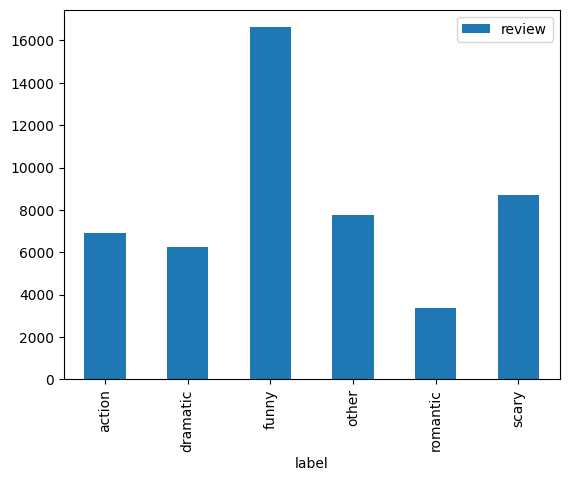

In [11]:
imdb_data['label'] = imdb_data.apply(label_data_filtered, axis=1)

print(len(imdb_data.groupby('label').count()))

imdb_data.groupby('label').count().plot.bar(ylim=0)

In [14]:
train_df = pd.concat([imdb_data, pd.get_dummies(imdb_data['label'], prefix='label')], axis=1)
train_df.drop(columns=['label'], inplace=True)
train_df

,review,label_action,label_dramatic,label_funny,label_other,label_romantic,label_scary
0,film brilliant casting location scenery story ...,0,0,1,0,0,0
1,big hair big boob bad music giant safety pin w...,0,0,0,0,0,1
2,one worst film friend watching film target aud...,0,1,0,0,0,0
3,scot excel storytelling traditional sort many ...,0,0,1,0,0,0
4,worst mistake life br br picked movie target f...,0,0,0,1,0,0
...,...,...,...,...,...,...,...
49995,book better film mostly writer prose saw film ...,0,0,1,0,0,0
49996,largest crowd ever see wrestling event u took ...,1,0,0,0,0,0
49997,suppose say terrible movie would unfair pretty...,1,0,0,0,0,0
49998,love third movie seemed creator took element f...,0,0,1,0,0,0


In [21]:
num_classes = 6

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['review'])
sequences = tokenizer.texts_to_sequences(train_df['review'])

max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

labels = pd.get_dummies(train_df[['label_action', 'label_dramatic', 'label_funny', 'label_other', 'label_romantic','label_scary']])

train_size = int(0.8 * len(train_df))
train_data = padded_sequences[:train_size]
train_labels = labels[:train_size].values
test_data = padded_sequences[train_size:]
test_labels = labels[train_size:].values

# Train KNN classifier for genre classification
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_data, train_labels)

KNeighborsClassifier()

In [24]:
# Predict genres for testing data
y_pred = knn.predict(test_data)

In [35]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.1061
